In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sea
import random
import tensorflow as tf
from keras.applications.mobilenet import MobileNet
from keras.preprocessing import image
from keras.applications.mobilenet import preprocess_input
from keras.layers import Dense, Dropout
from keras.models import Sequential
from keras.regularizers import l2
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils import shuffle
from sklearn import svm
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from sklearn.model_selection import GridSearchCV
from tabulate import tabulate
from IPython.display import display
from sklearn.multiclass import OneVsRestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import RidgeClassifierCV
from sklearn.neighbors import NearestCentroid
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
import lightgbm
from lightgbm import LGBMClassifier
from sklearn import svm

In [2]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

REPLICAS:  1


In [3]:
# load pretrained MobileNet
pre_trained_model = MobileNet(input_shape=(224,224,3), include_top=True, weights="imagenet")
pre_trained_model.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                         

In [4]:
vector = pre_trained_model.get_layer("reshape_2").output
feature_extractor = tf.keras.Model(pre_trained_model.input, vector)

In [5]:
labels = ['bellflower','daisy','dandelion','tulip','sunflower','rose','lotus','iris']
path = "D:/STUDY/CODE/ML/PredFlower/Data/flowers"

# create empty feature and label lists
x_list = []
y_list = []

for f in range(8):    
    folder_path = os.path.join(path, labels[f])
    for file in os.listdir(folder_path):    
        file_path = os.path.join(folder_path, file)
        # load image
        img = Image.open(file_path).convert("RGB")
        img = img.resize((224, 224))
        # convert image to numpy array
        img_arr = np.array(img)
        # add 1 more dimension
        img_arr_b = np.expand_dims(img_arr, axis=0)
        # preprocess image
        input_img = preprocess_input(img_arr_b)
        # extract feature
        feature_vec = feature_extractor.predict(input_img)
        x_list.append(feature_vec.ravel())
        y_list.append(f)

1/1 [==============================] - 2s 2s/step


In [6]:
x = np.asarray(x_list, dtype=np.float32)
y = np.asarray(y_list, dtype=np.float32)

for s in range(100):
    x, y = shuffle(x, y)
    
print("Shape of feature matrix X")
print(x.shape)
print("\nShape of label matrix Y")
print(y.shape)

class_types, counts = np.unique(y, return_counts=True)

print("\nClass labels")
print(class_types)
print("\nClass counts")
print(counts)

Shape of feature matrix X
(20137, 1000)

Shape of label matrix Y
(20137,)

Class labels
[0. 1. 2. 3. 4. 5. 6. 7.]

Class counts
[2513 2530 2500 2500 2501 2573 2501 2519]


In [7]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=y, random_state=40)

print("Shape of train_X")
print(x_train.shape)
print("\nShape of test_X")
print(x_test.shape)

Shape of train_X
(16109, 1000)

Shape of test_X
(4028, 1000)


In [8]:
class ConfusionMatrixPlot:
    def __init__(self, labels, y_true, y_pred):
        self.y_true = y_true
        self.y_pred = y_pred
        self.labels = labels 
    def plot(self):
        conf_matrix = confusion_matrix(y_true=self.y_true, y_pred=self.y_pred)
        vis = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=self.labels)
        plt.figure(figsize = (16,16))
        vis.plot(cmap="Blues")
        plt.xlabel('Predicted labels')
        plt.ylabel('True labels')
        plt.title('Confusion Matrix')
        plt.show()

In [16]:
class ClassificationReportPlot:
    def __init__(self,labels, true_labels, predicted_labels):
        self.true_labels = true_labels
        self.predicted_labels = predicted_labels
        self.labels = labels
    def plot(self):
        report = classification_report(self.true_labels, self.predicted_labels, target_names=labels, output_dict=True)
        report_df = pd.DataFrame(report).transpose()
        pd.set_option("display.max_rows", None)
        display(report_df)
        plt.show()

## SVM 

In [13]:
param_grid = [
    {'C': [3, 4 , 5], 'kernel': ['linear']},
    {'C': [3, 4 , 5],'gamma': [0.001, 0.0001], 'kernel': ['rbf']},
]
svm = svm.SVC()
grid_search = GridSearchCV(estimator=svm, param_grid=param_grid, scoring='accuracy', cv=5)
grid_search.fit(x_train, y_train)
best_model = grid_search.best_estimator_
print("Best Model:", best_model)
y_pred = best_model.predict(x_test)
confusion_plot = ConfusionMatrixPlot(labels, y_test, y_pred)
confusion_plot.plot()
report_plot = ClassificationReportPlot(labels, y_test, y_pred)
report_plot.plot()

AttributeError: 'SVC' object has no attribute 'SVC'

## RANDOM FOREST

Best Model: RandomForestClassifier(max_depth=50, n_estimators=400, n_jobs=-1,
                       random_state=50)


<Figure size 1600x1600 with 0 Axes>

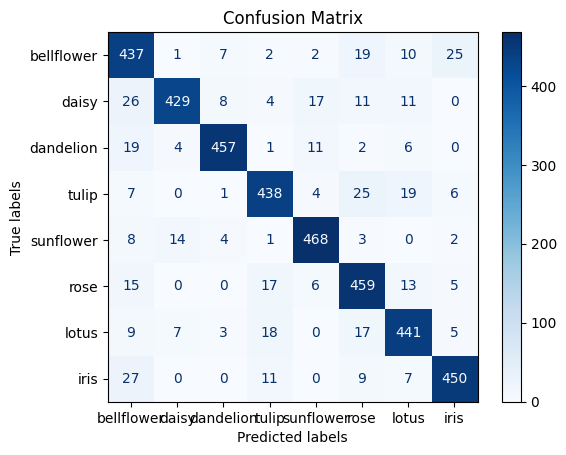

,precision,recall,f1-score,support
bellflower,0.797445,0.868787,0.831589,503.00000
daisy,0.942857,0.847826,0.892820,506.00000
dandelion,0.952083,0.914000,0.932653,500.00000
tulip,0.890244,0.876000,0.883065,500.00000
sunflower,0.921260,0.936000,0.928571,500.00000
rose,0.842202,0.891262,0.866038,515.00000
lotus,0.869822,0.882000,0.875869,500.00000
iris,0.912779,0.892857,0.902708,504.00000
accuracy,0.888530,0.888530,0.888530,0.88853
macro avg,0.891087,0.888592,0.889164,4028.00000


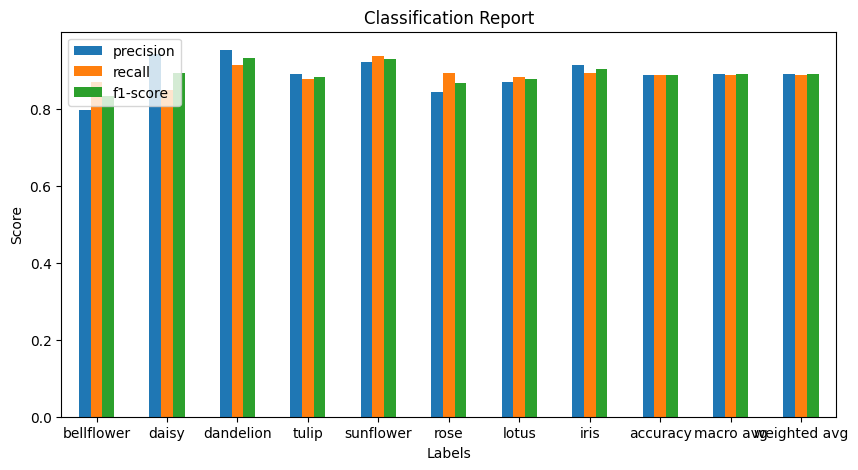

In [12]:
param_grid = {
    'n_estimators': [200, 300, 400],
    'max_depth': [30, 50, 70],}
random_forest = RandomForestClassifier(random_state=50, n_jobs=-1)
grid_search = GridSearchCV(estimator=random_forest, param_grid=param_grid, scoring='accuracy', cv=5)
grid_search.fit(x_train, y_train)
best_model = grid_search.best_estimator_
print("Best Model:", best_model)
y_pred = best_model.predict(x_test)
confusion_plot = ConfusionMatrixPlot(labels, y_test, y_pred)
confusion_plot.plot()
report_plot = ClassificationReportPlot(labels, y_test, y_pred)
report_plot.plot()

## XGBOOST

In [14]:
param_grid = {
    'estimator__learning_rate': [0.01, 0.1, 0.5],
    'estimator__max_depth': [30, 50, 100],
    'estimator__n_estimators': [100, 200, 300],}
XGBoost = OneVsRestClassifier(XGBClassifier(random_state=50, n_jobs=-1))
grid_search = GridSearchCV(estimator=XGBoost, param_grid=param_grid, scoring='accuracy', cv=5)
grid_search.fit(x_train, y_train)
best_model = grid_search.best_estimator_
print("Best Model:", best_model)
y_pred = best_model.predict(x_test)
confusion_plot = ConfusionMatrixPlot(labels, y_test, y_pred)
confusion_plot.plot()
report_plot = ClassificationReportPlot(labels, y_test, y_pred)
report_plot.plot()

KeyboardInterrupt: 

## K NEAREST NEIGHBOR

Best Model: KNeighborsClassifier(n_neighbors=7, weights='distance')


<Figure size 1600x1600 with 0 Axes>

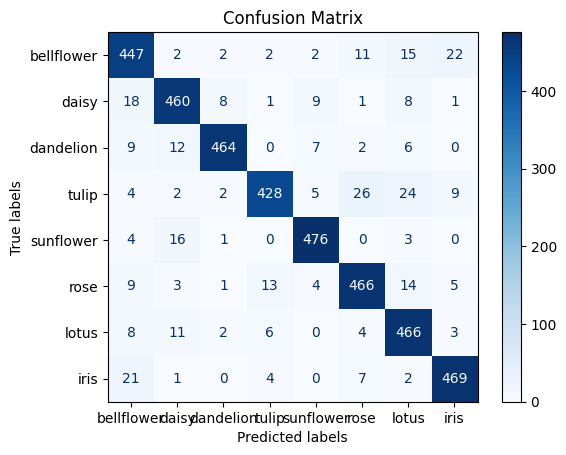

,precision,recall,f1-score,support
bellflower,0.859615,0.888668,0.873900,503.000000
daisy,0.907298,0.909091,0.908193,506.000000
dandelion,0.966667,0.928000,0.946939,500.000000
tulip,0.942731,0.856000,0.897275,500.000000
sunflower,0.946322,0.952000,0.949153,500.000000
rose,0.901354,0.904854,0.903101,515.000000
lotus,0.866171,0.932000,0.897881,500.000000
iris,0.921415,0.930556,0.925962,504.000000
accuracy,0.912612,0.912612,0.912612,0.912612
macro avg,0.913947,0.912646,0.912800,4028.000000


In [17]:
param_grid = {
    'n_neighbors': [7, 16, 17],
    'weights': ['uniform', 'distance']}
KNN = KNeighborsClassifier()
grid_search = GridSearchCV(estimator=KNN, param_grid=param_grid, scoring='accuracy', cv=5)
grid_search.fit(x_train, y_train)
best_model = grid_search.best_estimator_
print("Best Model:", best_model)
y_pred = best_model.predict(x_test)
confusion_plot = ConfusionMatrixPlot(labels, y_test, y_pred)
confusion_plot.plot()
report_plot = ClassificationReportPlot(labels, y_test, y_pred)
report_plot.plot()

## LOGISTIC REGRESSION

In [18]:
param_grid = {'C': [0.1, 1.0, 10.0],
              'solver': ['lbfgs', 'sag', 'saga'],
              'max_iter': [100, 500, 1000]}
logreg = LogisticRegression()
grid_search = GridSearchCV(logreg, param_grid)
grid_search.fit(x_train, y_train)
best_model = grid_search.best_estimator_
print("Best Model:", best_model)
y_pred = best_model.predict(x_test)
confusion_plot = ConfusionMatrixPlot(labels, y_test, y_pred)
confusion_plot.plot()
report_plot = ClassificationReportPlot(labels, y_test, y_pred)
report_plot.plot()

c:\Users\Nguyen Duc Thinh\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\Nguyen Duc Thinh\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https

KeyboardInterrupt: 

## BERNOULLI NAIVE BAYES

Best Model: BernoulliNB(alpha=0.1)


<Figure size 1600x1600 with 0 Axes>

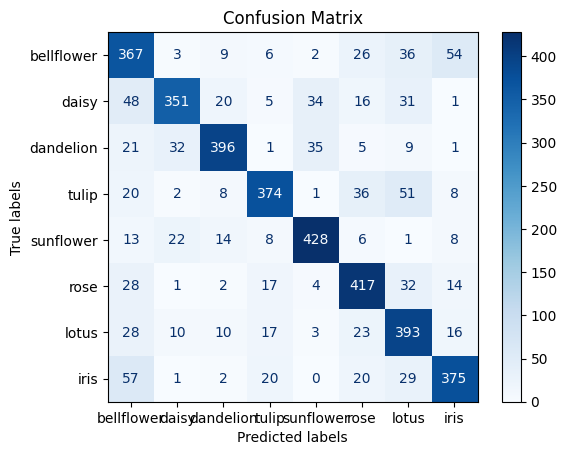

,precision,recall,f1-score,support
bellflower,0.630584,0.729622,0.676498,503.000000
daisy,0.831754,0.693676,0.756466,506.000000
dandelion,0.859002,0.792000,0.824142,500.000000
tulip,0.834821,0.748000,0.789030,500.000000
sunflower,0.844181,0.856000,0.850050,500.000000
rose,0.759563,0.809709,0.783835,515.000000
lotus,0.675258,0.786000,0.726433,500.000000
iris,0.786164,0.744048,0.764526,504.000000
accuracy,0.769861,0.769861,0.769861,0.769861
macro avg,0.777666,0.769882,0.771372,4028.000000


In [26]:
param_grid = {'alpha': [0.1, 1.0, 10.0]}
naive_bayes_BernoulliNB = BernoulliNB()
grid_search = GridSearchCV(naive_bayes_BernoulliNB, param_grid)
grid_search.fit(x_train, y_train)
best_model = grid_search.best_estimator_
print("Best Model:", best_model)
y_pred = best_model.predict(x_test)
confusion_plot = ConfusionMatrixPlot(labels, y_test, y_pred)
confusion_plot.plot()
report_plot = ClassificationReportPlot(labels, y_test, y_pred)
report_plot.plot()

## GAUSSIAN NAIVE BAYES

<Figure size 1600x1600 with 0 Axes>

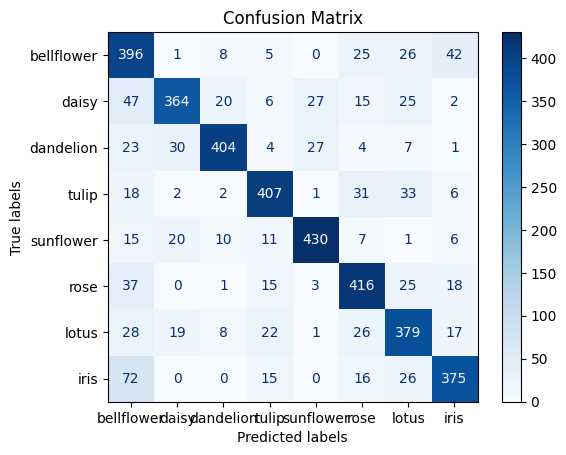

,precision,recall,f1-score,support
bellflower,0.622642,0.787276,0.695347,503.000000
daisy,0.834862,0.719368,0.772824,506.000000
dandelion,0.891832,0.808000,0.847849,500.000000
tulip,0.839175,0.814000,0.826396,500.000000
sunflower,0.879346,0.860000,0.869565,500.000000
rose,0.770370,0.807767,0.788626,515.000000
lotus,0.726054,0.758000,0.741683,500.000000
iris,0.802998,0.744048,0.772400,504.000000
accuracy,0.787239,0.787239,0.787239,0.787239
macro avg,0.795910,0.787307,0.789336,4028.000000


In [25]:
naive_bayes_GaussianNB = GaussianNB()
naive_bayes_GaussianNB.fit(x_train, y_train)
y_pred = naive_bayes_GaussianNB.predict(x_test)
confusion_plot = ConfusionMatrixPlot(labels, y_test, y_pred)
confusion_plot.plot()
report_plot = ClassificationReportPlot(labels, y_test, y_pred)
report_plot.plot()

## RIDGE CLASSIFICATION

c:\Users\Nguyen Duc Thinh\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=8.07241e-09): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\Users\Nguyen Duc Thinh\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=8.06937e-09): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\Users\Nguyen Duc Thinh\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=7.92335e-09): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\Users\Nguyen Duc Thinh\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=8.01855e-09): resul

Best Model: RidgeClassifier(alpha=0.1)


c:\Users\Nguyen Duc Thinh\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=8.01582e-09): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


<Figure size 1600x1600 with 0 Axes>

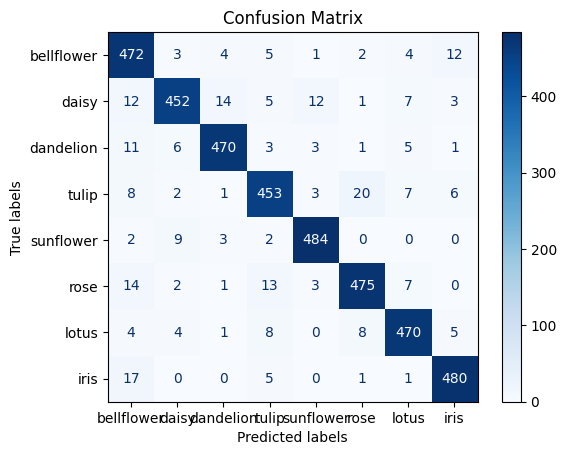

,precision,recall,f1-score,support
bellflower,0.874074,0.938370,0.905081,503.000000
daisy,0.945607,0.893281,0.918699,506.000000
dandelion,0.951417,0.940000,0.945674,500.000000
tulip,0.917004,0.906000,0.911469,500.000000
sunflower,0.956522,0.968000,0.962227,500.000000
rose,0.935039,0.922330,0.928641,515.000000
lotus,0.938124,0.940000,0.939061,500.000000
iris,0.946746,0.952381,0.949555,504.000000
accuracy,0.932473,0.932473,0.932473,0.932473
macro avg,0.933067,0.932545,0.932551,4028.000000


In [20]:
param_grid = {'alpha': [0.1, 1.0, 10.0]}
ridge_classifier = RidgeClassifier()
grid_search = GridSearchCV(ridge_classifier, param_grid)
grid_search.fit(x_train, y_train)
best_model = grid_search.best_estimator_
print("Best Model:", best_model)
y_pred = best_model.predict(x_test)
confusion_plot = ConfusionMatrixPlot(labels, y_test, y_pred)
confusion_plot.plot()
report_plot = ClassificationReportPlot(labels, y_test, y_pred)
report_plot.plot()

## NEAREST CENTROID

Best Model: NearestCentroid(shrink_threshold=1.0)


<Figure size 1600x1600 with 0 Axes>

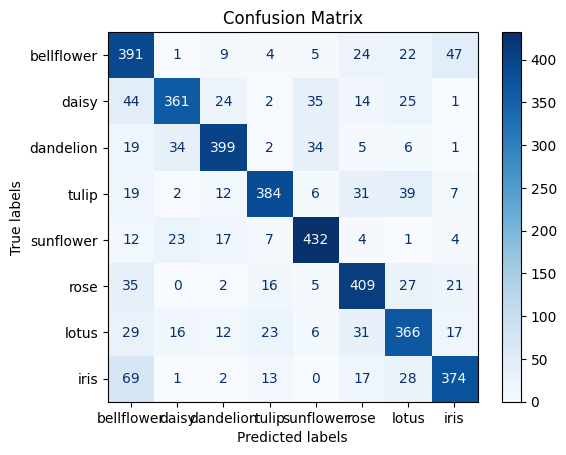

,precision,recall,f1-score,support
bellflower,0.632686,0.777336,0.697591,503.000000
daisy,0.824201,0.713439,0.764831,506.000000
dandelion,0.836478,0.798000,0.816786,500.000000
tulip,0.851441,0.768000,0.807571,500.000000
sunflower,0.826004,0.864000,0.844575,500.000000
rose,0.764486,0.794175,0.779048,515.000000
lotus,0.712062,0.732000,0.721893,500.000000
iris,0.792373,0.742063,0.766393,504.000000
accuracy,0.773585,0.773585,0.773585,0.773585
macro avg,0.779966,0.773627,0.774836,4028.000000


In [21]:
param_grid = {'shrink_threshold': [None, 0.1, 0.5, 1.0]}
nearest_centroid = NearestCentroid()
grid_search = GridSearchCV(nearest_centroid, param_grid)
grid_search.fit(x_train, y_train)
best_model = grid_search.best_estimator_
print("Best Model:", best_model)
y_pred = best_model.predict(x_test)
confusion_plot = ConfusionMatrixPlot(labels, y_test, y_pred)
confusion_plot.plot()
report_plot = ClassificationReportPlot(labels, y_test, y_pred)
report_plot.plot()

## DECISION TREE

Best Model: DecisionTreeClassifier(max_depth=10)


<Figure size 1600x1600 with 0 Axes>

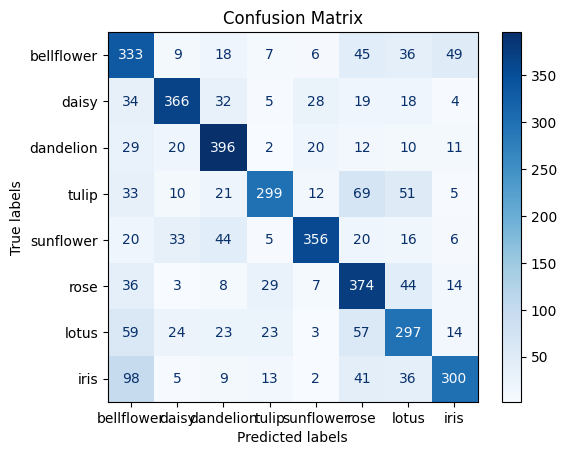

,precision,recall,f1-score,support
bellflower,0.518692,0.662028,0.581659,503.000000
daisy,0.778723,0.723320,0.750000,506.000000
dandelion,0.718693,0.792000,0.753568,500.000000
tulip,0.780679,0.598000,0.677237,500.000000
sunflower,0.820276,0.712000,0.762313,500.000000
rose,0.587127,0.726214,0.649306,515.000000
lotus,0.584646,0.594000,0.589286,500.000000
iris,0.744417,0.595238,0.661521,504.000000
accuracy,0.675521,0.675521,0.675521,0.675521
macro avg,0.691657,0.675350,0.678111,4028.000000


In [24]:
param_grid = {'max_depth': [None, 10, 20],
              'min_samples_split': [2, 5, 10]
}
decision_tree = DecisionTreeClassifier()
grid_search = GridSearchCV(decision_tree, param_grid)
grid_search.fit(x_train, y_train)
best_model = grid_search.best_estimator_
print("Best Model:", best_model)
y_pred = best_model.predict(x_test)
confusion_plot = ConfusionMatrixPlot(labels, y_test, y_pred)
confusion_plot.plot()
report_plot = ClassificationReportPlot(labels, y_test, y_pred)
report_plot.plot()

## RIDGE CLASSIFICATION CROSS VALIDATION

Best Model: RidgeClassifierCV()


<Figure size 1600x1600 with 0 Axes>

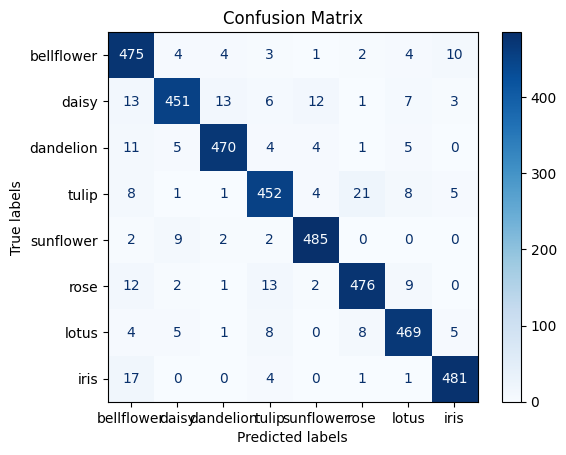

,precision,recall,f1-score,support
bellflower,0.876384,0.944334,0.909091,503.000000
daisy,0.945493,0.891304,0.917599,506.000000
dandelion,0.955285,0.940000,0.947581,500.000000
tulip,0.918699,0.904000,0.911290,500.000000
sunflower,0.954724,0.970000,0.962302,500.000000
rose,0.933333,0.924272,0.928780,515.000000
lotus,0.932406,0.938000,0.935194,500.000000
iris,0.954365,0.954365,0.954365,504.000000
accuracy,0.933217,0.933217,0.933217,0.933217
macro avg,0.933836,0.933284,0.933275,4028.000000


In [22]:
param_grid = {'alpha': [(0.1, 1.0, 10.0)]}
ridge_cv = RidgeClassifierCV()
grid_search = GridSearchCV(ridge_cv, param_grid=param_grid)
grid_search.fit(x_train, y_train)
best_model = grid_search.best_estimator_
print("Best Model:", best_model)
y_pred = best_model.predict(x_test)
confusion_plot = ConfusionMatrixPlot(labels, y_test, y_pred)
confusion_plot.plot()
report_plot = ClassificationReportPlot(labels, y_test, y_pred)
report_plot.plot()

## LIGHT GBM

Best Model: OneVsRestClassifier(estimator=LGBMClassifier(max_depth=30, n_estimators=300,
                                             random_state=50))


<Figure size 1600x1600 with 0 Axes>

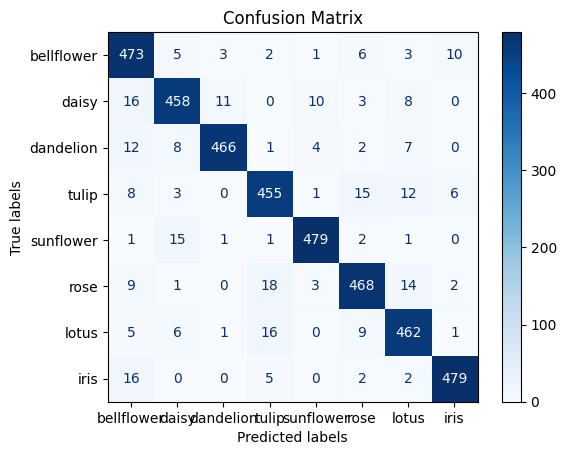

,precision,recall,f1-score,support
bellflower,0.875926,0.940358,0.906999,503.0000
daisy,0.923387,0.905138,0.914172,506.0000
dandelion,0.966805,0.932000,0.949084,500.0000
tulip,0.913655,0.910000,0.911824,500.0000
sunflower,0.961847,0.958000,0.959920,500.0000
rose,0.923077,0.908738,0.915851,515.0000
lotus,0.907662,0.924000,0.915758,500.0000
iris,0.961847,0.950397,0.956088,504.0000
accuracy,0.928500,0.928500,0.928500,0.9285
macro avg,0.929276,0.928579,0.928712,4028.0000


In [23]:
param_grid = {
    'estimator__max_depth': [30, 20, 40],
    'estimator__n_estimators': [400, 250, 300],}
LightGBM = OneVsRestClassifier(lightgbm.LGBMClassifier(random_state=50, n_jobs=-1))
grid_search = GridSearchCV(estimator=LightGBM, param_grid=param_grid, scoring='accuracy', cv=5)
grid_search.fit(x_train, y_train)
best_model = grid_search.best_estimator_
print("Best Model:", best_model)
y_pred = best_model.predict(x_test)
confusion_plot = ConfusionMatrixPlot(labels, y_test, y_pred)
confusion_plot.plot()
report_plot = ClassificationReportPlot(labels, y_test, y_pred)
report_plot.plot()

## CATBOOST

In [ ]:
from catboost import CatBoostClassifier
param_grid = {
    'estimator__depth': [6, 8, 10],
    'estimator__iterations': [100, 200, 300],
}
CatBoost = OneVsRestClassifier(CatBoostClassifier(random_state=50, verbose=False))
grid_search = GridSearchCV(estimator=CatBoost, param_grid=param_grid, scoring='accuracy', cv=5)
grid_search.fit(x_train, y_train)
best_model = grid_search.best_estimator_
print("Best Model:", best_model)
y_pred = best_model.predict(x_test)
confusion_plot = ConfusionMatrixPlot(labels, y_test, y_pred)
confusion_plot.plot()
report_plot = ClassificationReportPlot(labels, y_test, y_pred)
report_plot.plot()